In [2]:
# Import Basic Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats

# Exploratory Analysis fo Bayesian Models
import arviz as az

# Probabilistic Programming Language
import pymc as pm
import aesara

# Plottiing
import matplotlib.pyplot as plt

# An Introduction to Bayesian Thinking

Source: [Probabilistic Programming and Bayesian Methods for Hackers - Chapter 1](https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb)

In [40]:
# define a beta distribution
dist = stats.beta

# create a vector with different trials sizes
n_trials =[0,1,2,3,4,5,8,15,50,500]

# generate data i.e. coin tosses
data = stats.bernoulli.rvs(0.5, size =n_trials[-1])

# generate equally spaced vector as help for plotting later
x=np.linspace(0,1,100)

## Hierarchical Models
Source: [GLM - Hierarchical Linear Regression](https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html)

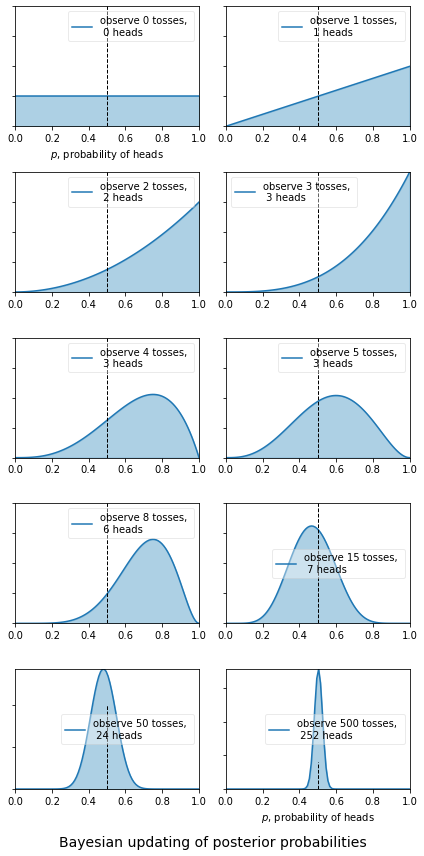

In [41]:
for k, N in enumerate(n_trials):
    # prepare plots
    sx = plt.subplot(int(len(n_trials)/2),2,k+1)
    plt.xlabel('$p$, probability of heads') \
    if k in [0,len(n_trials)-1] else None 
    plt.setp(sx.get_yticklabels(), visible=False)
    
    # number of heads observed
    heads = data[:N].sum()

    # get beta distribution over 0-1 interval for 'observed' coin tosses
    y = dist.pdf(x, 1+ heads, 1+N-heads)

    # plot the whole thing
    plt.plot(x,y,label='observe %d tosses, \n %d heads' % (N,heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)
    plt.suptitle("Bayesian updating of posterior probabilities",
                y=0,
                fontsize=14)

    plt.tight_layout(rect=(0,0,1,3))

## Bayesian Regression Models
Source: [Bayesian GLMs made easy with PYMC3](https://twiecki.io/blog/2013/08/12/bayesian-glms-1/)

In [135]:
# generate some simulated data
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

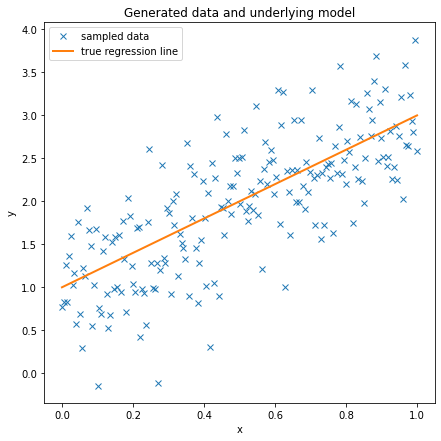

In [31]:
# visualise it
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [35]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x, 
                        sd=sigma, observed=y)
    
    # Inference!
    trace = pm.sample(progressbar=True) # draw posterior samples using NUTS sampling

/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_7267/2892163159.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


<Figure size 504x504 with 0 Axes>

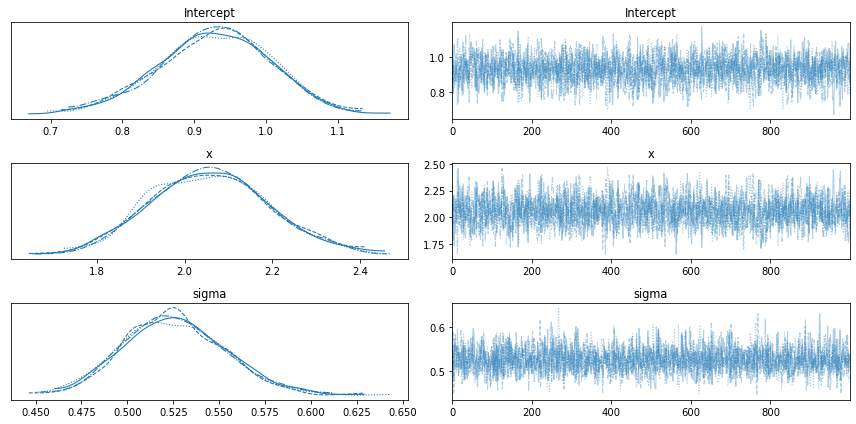

In [42]:
plt.figure(figsize=(7, 7))
az.plot_trace(trace)
plt.tight_layout();


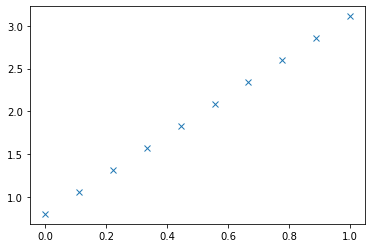

In [75]:
test = trace.posterior.data_vars['x'][0][0].values*np.linspace(0,1,10) + trace.posterior.data_vars['Intercept'][0][0].values
plt.plot(np.linspace(0,1,10), test, 'x', label='data')

In [143]:
import random
beta_1 = np.random.choice(np.array(trace.posterior.data_vars['x']).flatten(), size = 100)
beta_0 = np.random.choice(np.array(trace.posterior.data_vars['Intercept']).flatten(), size = 100)
y_sim = np.add(np.transpose(np.outer(beta_1,x)),beta_0)

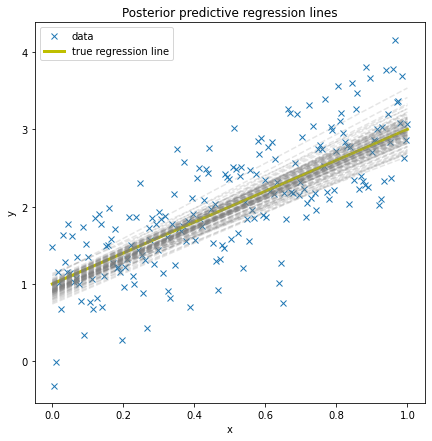

In [144]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
#az.plot_posterior_predictive_glm(trace, samples=100, 
                                  #  label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')
plt.plot(x,y_sim,'--',color='grey', alpha=0.2)
plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');


"Gelman et al.’s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all counties of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil. Here we’ll investigate this differences and try to make predictions of radonlevels in different counties based on the county itself and the presence of a basement. In this example we’ll look at Minnesota, a state that contains 85 counties in which different measurements are taken, ranging from 2 to 116 measurements per county."


## Hierarchical Models
Source: [GLM - Hierarchical Linear Regression](https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html)

In [145]:
data = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc4/master/notebooks/data/radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values

data[['county', 'log_radon', 'floor']].head()


,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


### The Models
#### Pooling of Measurements
Let's say we want to know whether having a basement has an influence on the radon measured in the house.

First Intuition - estimate
$$radon_{i,c} = \alpha + \beta * floor_{i,c} + \epsilon$$

where $i$ represents the measurement, $c$ the county and floor contains a 0 or 1 if the house has a basement or not, respectively. This means we only estimate one interceept and one slope for all measurements over all counties pooled together (like we did in the last example with the simulated data).

#### Unpooling
But what if we are intersted in whether different counties have different relationships (i.e. slope) and different base reates (i.e. intercept) of radon.

Thus we want to estimate the following:
$$radon_{i,c} = \alpha_{c} + \beta_c * floor_{i,c} + \epsilon_c$$

This means we are estimatin $n$ different $\alpha$s and $\beta$s - one for each county. Thus we are assuming that the counties do not share any similarities whatsoever. This can be a very noisy model when we have little data per county.


In [146]:
# factorize counties
county_idxs, counties = pd.factorize(data.county)
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}

In [148]:
with pm.Model(coords=coords) as unpooled_model:

    # Independent parameters for each county
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    floor = pm.Data("floor", data.floor.values, dims="obs_id")

    a = pm.Normal("a", 0, sigma=100, dims="county")
    b = pm.Normal("b", 0, sigma=100, dims="county")

    # Model error
    eps = pm.HalfCauchy("eps", 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx] * floor

    # Data likelihood
    y = pm.Normal("y", radon_est, sigma=eps, observed=data.log_radon, dims="obs_id")

/Users/htr365/opt/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/data.py:647: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


In [149]:
with unpooled_model:
    unpooled_trace = pm.sample(2000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


### Hierarchical Regression

Hierarchical Regression allows for an inbetween an unpooled and completely pooled regression. We assume that $\alpha$s and $\beta$s are different for each county (as in the unpooled regression) but that they come from a common distribution (i.e. they share some similarity):
$$\alpha_c ~ N(\mu_\alpha, \sigma^2_\alpha)$$
$$\beta_c ~ N(\mu_\beta, \sigma^2_\beta)$$


In [150]:
with pm.Model(coords=coords) as hierarchical_model:
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="county")
    # effect difference between basement and floor level
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like", mu=radon_est, sigma=eps, observed=data.log_radon, dims="obs_id"
    )


/Users/htr365/opt/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/data.py:647: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


In [154]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 516 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5036, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


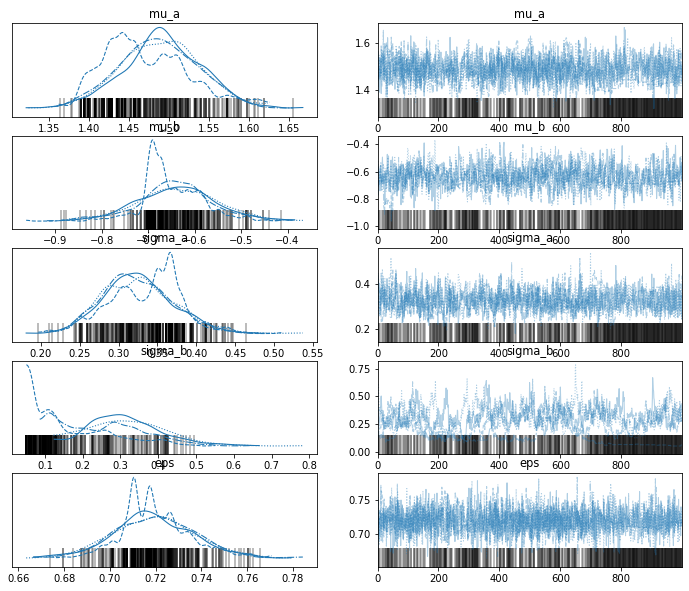

In [155]:
az.plot_trace(hierarchical_trace, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b", "eps"]);

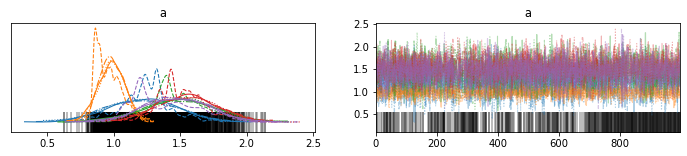

In [156]:
az.plot_trace(hierarchical_trace, var_names=["a"], coords={"county": counties[:5]});

"The marginal posteriors in the left column are highly informative. mu_a tells us the group mean (log) radon levels. mu_b tells us that having no basement decreases radon levels significantly (no mass above zero). We can also see by looking at the marginals for a that there is quite some differences in radon levels between counties (each ‘rainbow’ color corresponds to a single county); the different widths are related to how much confidence we have in each parameter estimate – the more measurements per county, the higher our confidence will be."

In [159]:
import xarray as xr
selection = ["CASS", "CROW WING", "FREEBORN"]
xvals = xr.DataArray(np.linspace(-0.2, 1.2, num=85), dims=["x_plot"])

unpooled_post = unpooled_trace.posterior.stack(chain_draw=("chain", "draw"))
hier_post = hierarchical_trace.posterior.stack(chain_draw=("chain", "draw"))

hier_post

<xarray.Dataset>
Dimensions:     (chain_draw: 4000, county: 85)
Coordinates:
  * county      (county) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    mu_a        (chain_draw) float64 1.544 1.414 1.489 ... 1.435 1.493 1.438
    mu_b        (chain_draw) float64 -0.7753 -0.5536 -0.614 ... -0.6317 -0.666
    a           (county, chain_draw) float64 1.476 1.159 1.447 ... 1.378 1.367
    b           (county, chain_draw) float64 -0.4088 -0.8208 ... -0.7446 -0.458
    sigma_a     (chain_draw) float64 0.2397 0.2928 0.3442 ... 0.3382 0.4357
    sigma_b     (chain_draw) float64 0.316 0.3838 0.3463 ... 0.2963 0.2828 0.281
    eps         (chain_draw) float64 0.7362 0.6943 0.7315 ... 0.7102 0.7224
Attributes:
    created_at:                 2022-05-03T14:06:50.298933
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b4
    sampling_time:              28.792640924453735
    tuning_steps:               1000

In [160]:
obs_county = unpooled_post["county"].isel(county=unpooled_trace.constant_data["county_idx"])
observed_data = unpooled_trace.observed_data.assign_coords(
    floor=unpooled_trace.constant_data["floor"]
)

observed_data

<xarray.Dataset>
Dimensions:  (obs_id: 919)
Coordinates:
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 ... 911 912 913 914 915 916 917 918
    floor    (obs_id) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    y        (obs_id) float64 0.8329 0.8329 1.099 0.09531 ... 1.629 1.335 1.099
Attributes:
    created_at:                 2022-05-03T14:02:27.511276
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b4

In [161]:
unpooled_est = (unpooled_post["a"] + unpooled_post["b"] * xvals).transpose("x_plot", ...)
hier_est = (hier_post["a"] + hier_post["b"] * xvals).transpose("x_plot", ...)

In [162]:
rng = np.random.default_rng(0)

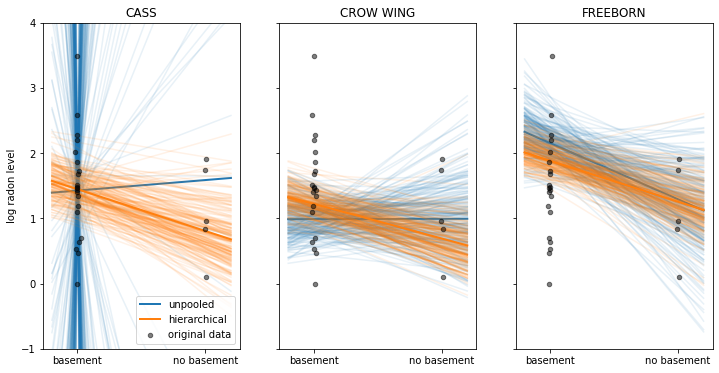

In [163]:
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()

random_subset = rng.permutation(np.arange(len(hier_est["chain_draw"])))[:200]

for i, c in enumerate(selection):
    ### unpooled model ###
    unpooled_c = unpooled_est.sel(county=c)
    unpooled_means = unpooled_post.sel(county=c).mean()
    # plot all samples from unpooled model
    axis[i].plot(xvals, unpooled_c.isel(chain_draw=random_subset), color="C0", alpha=0.1)
    # plot mean from unpooled model
    axis[i].plot(
        xvals,
        unpooled_means["a"] + unpooled_means["b"] * xvals,
        color="C0",
        alpha=1,
        lw=2.0,
        label="unpooled",
    )
    ### hierarchical model ##
    hier_c = hier_est.sel(county=c)
    hier_means = hier_post.sel(county=c).mean()
    # plot all samples
    axis[i].plot(xvals, hier_c.isel(chain_draw=random_subset), color="C1", alpha=0.1)
    # plot mean
    axis[i].plot(
        xvals,
        hier_means["a"] + hier_means["b"] * xvals,
        color="C1",
        alpha=1,
        lw=2.0,
        label="hierarchical",
    )
    # observed_data
    obs_data_c = observed_data.where(obs_county.isin(selection), drop=True)
    axis[i].scatter(
        obs_data_c["floor"] + rng.normal(scale=0.01, size=len(obs_data_c["floor"])),
        obs_data_c["y"],
        alpha=0.5,
        color="k",
        marker=".",
        s=80,
        zorder=3,
        label="original data",
    )
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["basement", "no basement"])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel("log radon level")

"In the above plot we have the data points in black of three selected counties. The thick lines represent the mean estimate of the regression line of the individual (blue) and hierarchical model (in green). The thinner lines are regression lines of individual samples from the posterior and give us a sense of how variable the estimates are.

When looking at the county ‘CASS’ we see that the non-hierarchical estimation is strongly biased: as this county’s data contains only households with a basement the estimated regression produces the non-sensical result of a giant negative slope meaning that we would expect negative radon levels in a house without basement!

Moreover, in the example county’s ‘CROW WING’ and ‘FREEBORN’ the non-hierarchical model appears to react more strongly than the hierarchical model to the existance of outliers in the dataset (‘CROW WING’: no basement upper right. ‘FREEBORN’: basement upper left). Assuming that there should be a higher amount of radon gas measurable in households with basements opposed to those without, the county ‘CROW WING’’s non-hierachical model seems off. Having the group-distribution constrain the coefficients we get meaningful estimates in all cases as we apply what we learn from the group to the individuals and vice-versa."

# A/B Testing Example

Source: [Probabilistic Programming and Bayesian Methods for Hackers - Chapter 2](https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb)

Assume there is some true probability $0<p_A<1>$ that users who, after being shown site A also purchase from the site. This is the true effectiveness of site A. It is currently unknown to us.

Suppose site A was shown to $N$ people and $n$ people purchased from the site. One might conclude hastily $p_A=\frac{n}{N}$. Unfortunately, the *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$ - there is a differnce between *observed frequency* and *true frequency* of an event. The true frequency can be itnerpreted as the probability of an event ocurring. e.g. the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$.

The *observed frequency* is the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency , $0.2$ differs from the true frequency $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.

To setup a Bayesian model, we need to assign prior distributions to our unknown quantities. A priori, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume pA is uniform over [0,1]:

In [12]:
# In PyMC3, we typically handle all the variables we want in our model within the context of the Model object.
# Any variables created within a given Model's context will be automatically assigned to that model.
# If you try to define a variable outside of the context of a model, you will get an error.

with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

For this example consider $p_A=0.05$ and $N=1500$ users shown the site A and we will simulate wether the user made a purchase or not. To simulate this from $N$ trials, we will use a Bernoulli distribution: if $ X ~ Ber(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1-p$. Of course in practice we do not know $p_A$ but we will use it here to simulate data.

In [13]:
# set constants
p_true = 0.05 # remember, this is unkonwn!
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step

occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences)
print(np.sum(occurrences))

[1 0 0 ... 0 0 0]
75


In [14]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0500
Does this equal the true frequency? True


In [15]:
# We can continue to work within the context of the same model by using with with the name of the model object that we have already created.
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # sampling algorithm to get posterior distrubtion - more on this later
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
  

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 27 seconds.


<AxesSubplot:title={'center':'p'}>

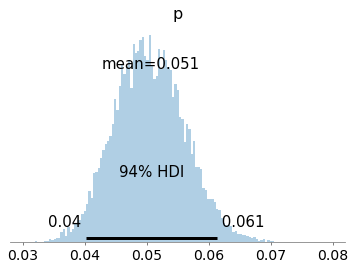

In [16]:
# plot posterior
az.plot_posterior(trace,kind='hist')

In [17]:
# We can examine the same variables outside of the model context once they have been defined, but to define more variables that the model will recognize they have to be within the context.

Now what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$ and $delta=p_A -p_B$ all at once. We assume for the exercise that $p_B=0.04$ so $delta=0.01$ and $N_B=750$.

In [18]:
#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [19]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.042
0.037333333333333336


In [20]:
# set up the pymc3 Model. 
with pm.Model() as model:
    # Again assign uniform priors for p_A and p_B
    p_A = pm.Uniform('p_A',0,1)
    p_B = pm.Uniform('p_B',0,1)

    # Define the dterministic delta function. This is our unkown of interest.
    delta = pm.Deterministic('delta', p_A-p_B)

    # Set of observations, in this case we have to observation datasets
    obs_A = pm.Bernoulli('obs_A',p_A, observed=observations_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed = observations_B)

    step =pm.Metropolis()
    trace = pm.sample(2000, step =step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_A]
>Metropolis: [p_B]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


array([<AxesSubplot:title={'center':'p_A'}>,
       <AxesSubplot:title={'center':'p_B'}>,
       <AxesSubplot:title={'center':'delta'}>], dtype=object)

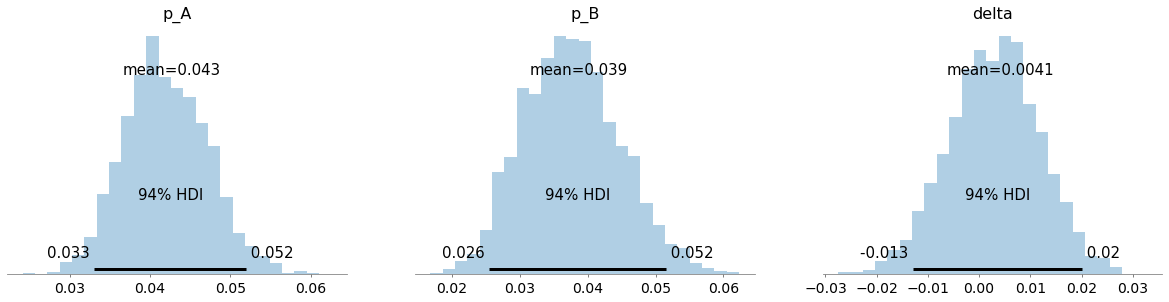

In [21]:
# plot posterior
az.plot_posterior(trace, kind='hist', var_names =['p_A','p_B','delta'], bins=25)

In [22]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(trace.posterior.delta < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(trace.posterior.delta> 0))

Probability site A is WORSE than site B: 0.320
Probability site A is BETTER than site B: 0.680


## Survival Analysis

Most of this is taken from [this](https://docs.pymc.io/en/v3/pymc-examples/examples/survival_analysis/survival_analysis.html) tutorial.

In [35]:
# load dataset
df = pd.read_csv('/Users/htr365/Documents/PhD/mastectomy.csv')

In [36]:
# transform to numeric and get patient count
df.event = df.event.astype(np.int64)
df.metastized = (df.metastized =='yes').astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

# take a look at data structure
df.head()

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


In [37]:
n_patients

44

Survival analysis is primarily interested in the time to event $t$. 
This is usually modelled via a survival function:
$$ S(t) = P(T>t) = 1-F(t)$$

where $F$ is the Cumulative Distribution Function of $T$. The survival function is often expressed in terms of the hazard rate $\lambda(t)$. It is the probability that the event occurs at time $t$ given that it hasn't occured yet.

$$ \lambda(t) = \lim_{\Delta \rightarrow 0} \frac{P(t<T<t+\Delta t | T>t)}{\Delta t} = \lim_{\Delta \rightarrow 0} \frac{P(t<T<t+\Delta t)}{\Delta t * P(T>t)}= \frac{1}{S(t)}*\lim_{\Delta \rightarrow 0} \frac{S(t)-S(t+\Delta t)}{\Delta t} = -\frac{S'(t)}{S(t)}$$

Solving the differential equation for the survival function shows that
$$S(t) = exp( - \int_0^s \lambda(s)ds)$$

This representation of the survival function shows that the cumulative hazard function
$$\Lambda (t) = \int_0^t \lambda(s) ds$$
is an important quantity in survival analysis, since we may concisely write $S(t) = exp(-\Lambda (t))$


An important, but subtle, point in survival analysis is censoring. Even though the quantity we are interested in estimating is the time between surgery and death, we do not observe the death of every subject. At the point in time that we perform our analysis, some of our subjects will thankfully still be alive. In the case of our mastectomy study, df.event is one if the subject’s death was observed (the observation is not censored) and is zero if the death was not observed (the observation is censored).


In [6]:
df.event.mean()

0.5909090909090909

This means that just over 40% of the observations are censored.

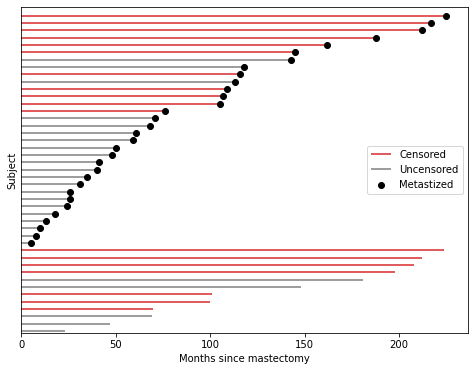

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hlines(
    patients[df.event.values == 0], 0, df[df.event.values == 0].time, color="C3", label="Censored"
)

ax.hlines(
    patients[df.event.values == 1], 0, df[df.event.values == 1].time, color="C7", label="Uncensored"
)

ax.scatter(
    df[df.metastized.values == 1].time,
    patients[df.metastized.values == 1],
    color="k",
    zorder=10,
    label="Metastized",
)

ax.set_xlim(left=0)
ax.set_xlabel("Months since mastectomy")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc="center right");



In this case we want to study the effect of metastization on survival time (in a social science case this could be some kind of treatment), due to that a risk regression model is most appropriate. The most common one is Cox's proportioinal hazards model. In this model the hazard rate is modelled as
$$\lambda (t) = \lambda_0 (t) exp(x \beta)$$

where $x$ are covariates and $\beta$ are the regression coefficients. $\lambda_0$ is the base hazard rate which is independent of the covariates.

In order to perform Bayesian inference we need some priors.
For $\beta$ we choose a normal prior $\beta ± N(\mu_\beta, \sigma^2_\beta)$ where $\mu_\beta ± N(0,10^2)$ and $\sigma_\beta ± U(0,10)$

It is not so obvious how to choose a prior for $\lambda_0(t)$, thus we choose a semi-parametric prior with a piecewise constant function. For that, we have to partition the time range in question into intervals with endpoints $0 \leq s_1 < s_2 < \dots <s_N$>. With this partition, $\lambda_{0(t)} = \lambda_j$ if $s_j \leq t < s_{j+1}$. With $\lambda_0(t)$ constrained to this form, we also need to choose priors for the $N-1$ values $\lambda_j$. We use independent vaue priors $\lambda_j ~ Gamma(10%{-2},10^{-2})$. For this example we make each interval 3 months long.

In [9]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

last_period = np.floor((df.time - 0.01) / interval_length).astype(int)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event


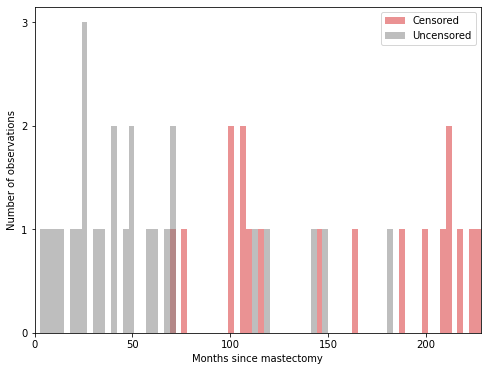

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(
    df[df.event == 0].time.values,
    bins=interval_bounds,
    lw=0,
    color="C3",
    alpha=0.5,
    label="Censored",
)

ax.hist(
    df[df.event == 1].time.values,
    bins=interval_bounds,
    lw=0,
    color="C7",
    alpha=0.5,
    label="Uncensored",
)

ax.set_xlim(0, interval_bounds[-1])
ax.set_xlabel("Months since mastectomy")

ax.set_yticks([0, 1, 2, 3])
ax.set_ylabel("Number of observations")

ax.legend();



Define an indicator variable based on wether the i-th subject died in the j-th interval.

In [39]:
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event



Also define $t_{i,j}$ to be the amount of time the ith subject was at risk in the jth interval (i.e. this is just the length of the interval i.e. 3 if the person was alive and 0 otherwise)

In [40]:
exposure = np.greater_equal.outer(df.time.to_numpy(), interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

We denote the risk incurred by the ith subject in the jth interval as $\lambda_{i,j} = \lambda_j exp(x_i,\beta)$. We may approximate $d_{i,j}$ with a poisson random variable with mean $t_{i,j} \lambda_{i,j}$.

In [27]:
df

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0
5,101,0,0
6,148,1,0
7,181,1,0
8,198,0,0
9,208,0,0


In [53]:
T._shared(df.metastized)

TypeError: 

In [86]:


with pm.Model() as model:

    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)

    beta = pm.Normal('beta', 0, sd=1000)
    #print(np.outer(beta * df.metastized.values, lambda0))
    lambda_ = pm.Deterministic('lambda_', aesara.tensor.math.outer(pm.math.exp(beta * df.metastized.values),lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)

    obs = pm.Poisson('obs', mu, observed=death)

In [67]:
n_samples = 1000
n_tune = 1000

In [104]:
SEED = 5078864
with model:
    idata =  pm.sample(n_samples, tune=n_tune, nuts = {'target_accept': 0.99}, random_seed=SEED, return_inference_data=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 255 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


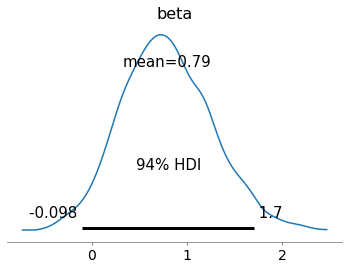

In [105]:
az.plot_posterior(idata, var_names=["beta"]);

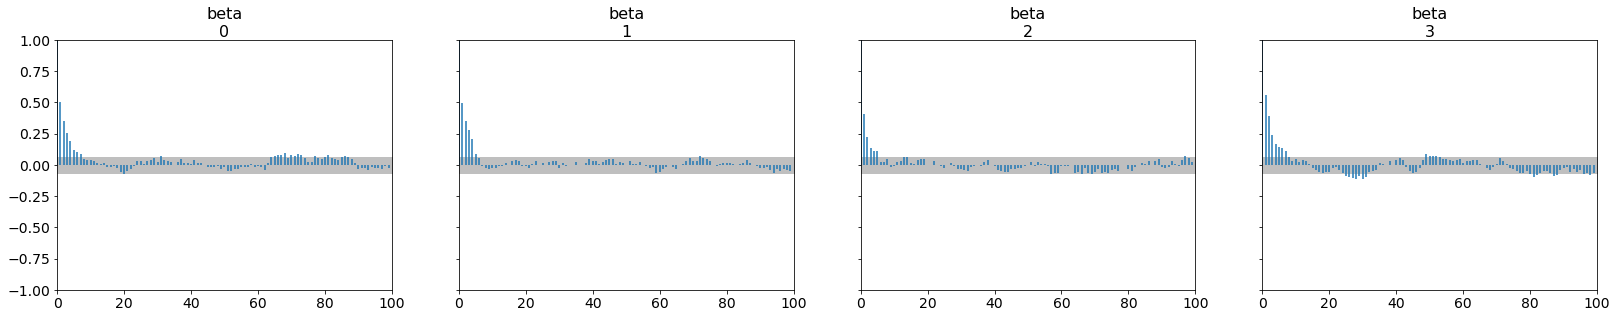

In [106]:
az.plot_autocorr(idata, var_names=["beta"]);

In [107]:
# effect of metastization on cumulative hazard and survival function
base_hazard = idata.posterior["lambda0"]
met_hazard = idata.posterior["lambda0"] * np.exp(idata.posterior["beta"])



In [108]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("chain", "draw"))

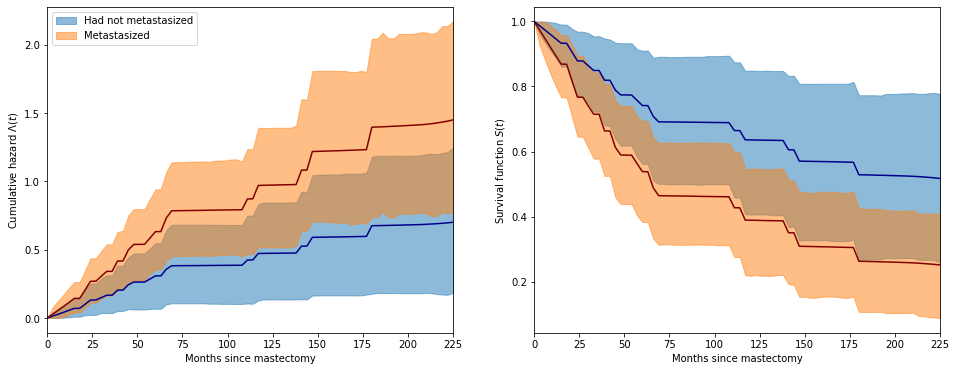

In [109]:
ig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(base_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Had not metastasized"},
)
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Metastasized"},
)

hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(base_hazard)), color="darkblue")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(met_hazard)), color="maroon")

hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel("Months since mastectomy")
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(interval_bounds[:-1], survival(base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(interval_bounds[:-1], get_mean(survival(base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(met_hazard)), color="maroon")

surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel("Months since mastectomy")
surv_ax.set_ylabel("Survival function $S(t)$")

fig.suptitle("Bayesian survival model");